Only reading in one email for now

In [1]:
emailDir = "./maildir/maildir"
enroncsv = "../experiments/enron.csv"
metadataHeaders = '../experiments/metadataHeaders.csv'
spam = '../experiments/spam.csv'
spamSubjects = '../experiments/spamWords.txt'

In [2]:
import pandas as pd

columns = pd.read_csv(metadataHeaders, sep=',').columns.tolist()
columns

['Filename',
 'Person',
 'Directory',
 'Message-ID',
 'Date',
 'From',
 'To',
 'Subject',
 'Cc',
 'Time',
 'Attendees',
 'Re',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'Bcc',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName']

In [3]:
df = pd.read_csv(enroncsv, names=columns, sep='|', low_memory=False)

print("-- DONE --")

-- DONE --


Lets query for a mail that does not have `Message-ID` with `.JavaMail.evans@thyme`

In [4]:
result = df[pd.notnull(df['Message-ID'])]

result = result.loc[~result['Message-ID'].str.contains('.JavaMail.evans@thyme')]
result

,Filename,Person,Directory,Message-ID,Date,From,To,Subject,Cc,Time,...,Content-Type,Content-Transfer-Encoding,Bcc,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName


In [5]:
result = df[pd.notnull(df['Subject'])]

result = result.loc[result['Subject'].str.contains('Porn')]
len(result)

25

No results so the server `.JavaMail.evans@thyme` is not helpfull

Lets count the number of non null fields per header and make it a percentage over the total number of parsable emials

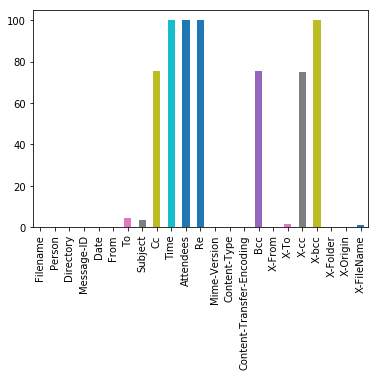

Filename                      0.000000
Person                        0.000000
Directory                     0.000000
Message-ID                    0.000387
Date                          0.000387
From                          0.000387
To                            4.222880
Subject                       3.713189
Cc                           75.279489
Time                         99.999807
Attendees                    99.994201
Re                           99.998840
Mime-Version                  0.011597
Content-Type                  0.011597
Content-Transfer-Encoding     0.010631
Bcc                          75.284322
X-From                        0.011404
X-To                          1.770680
X-cc                         75.084079
X-bcc                        99.959410
X-Folder                      0.012370
X-Origin                      0.006958
X-FileName                    0.820493
dtype: float64

In [33]:
import matplotlib.pyplot as plt

numberOfRows = len(df.index)
missingData = (numberOfRows - df.count()) / numberOfRows * 100
plot = missingData.plot(kind='bar')

plt.show()
missingData

How many people flolders don't match their X-origin

In [7]:
len(df.loc[df['Person'] != df['X-Origin'].str.lower()])

35496

How many different `Content-Type`'s are in the dataset

In [8]:
df['Content-Type'].unique()

array([nan, 'text/plain; charset="us-ascii"',
       'text/plain; charset="ANSI_X3.4-1968"'], dtype=object)

How many different `Content-Transfer-Encoding`'s are in the dataset

In [9]:
df['Content-Transfer-Encoding'].unique()

array([nan, '7bit', 'quoted-printable', 'base64',
       '\\JSKILLIN (Non-Privileged)\\Deleted Items', '\\jskillin\\Inbox',
       '\\HARORA (Non-Privileged)\\Arora, Harry\\Deleted Items',
       '\\HARORA (Non-Privileged)\\Arora, Harry\\Inbox',
       'EID: <24606> ERe: <0>'], dtype=object)

How many different `Mime-Version`'s are in the dataset

In [10]:
df['Mime-Version'].unique()

array([nan,  1.])

Lets remove those colums that are almost never filled in or that are irrelevent

In [11]:
removableColumns = ['Time', 'Attendees', 'Bcc', 'X-bcc', 'X-cc', 'X-Origin']

import csv
with open('removableColumns.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for col in removableColumns:
        writer.writerow([col])

df.drop(removableColumns, axis=1)

print('-- DONE --')

-- DONE --


In [12]:
listOfEmailsForBagOfWords = df.loc[df['Directory'].str.contains('inbox')]

print('-- DONE --')

-- DONE --


In [13]:
wordsPerEmail = df[pd.notnull(df['Subject'])]
nonSpamSubjects = wordsPerEmail['Subject']
wordsPerEmail = nonSpamSubjects.str.split(' ')
len(wordsPerEmail)

498161

In [14]:
import string
printable = set(string.printable)

def isEnglish(s):
    for x in s:
        if x not in printable:
            return False
    return True

def addToBagOfWords(dictionary, arr):
    for word in arr:
        word = word.lower()
        
        if '=' in word:
            continue
        if '/' in word:
            continue
        if '\\' in word:
            continue
        if '_' in word:
            continue
        if '-' in word:
            continue
        if ':' in word:
            continue
        if '@' in word:
            continue
        if '#' in word:
            continue
        if '$' in word:
            word = '$'

        word = word.replace('.', '')
        word = word.replace(')', '')
        word = word.replace('(', '')
        word = word.replace('&', '')
        word = word.replace('\'', '')
        word = word.replace('\"', '')
        word = word.replace(',', '')
        word = word.replace('[', '')
        word = word.replace(']', '')
        word = word.replace('{', '')
        word = word.replace('}', '')
        word = word.replace(';', '')

        if word == '':
            continue

        if word in dictionary:
            dictionary[word] = dictionary[word] + 1
        else:
            dictionary[word] = 1
            
    return dictionary

In [15]:
def addToDictionary(dictionary, arr):
    for index, subject in arr.iteritems():
        dictionary = addToBagOfWords(dictionary, subject)
                
    return dictionary

In [16]:
dictionary = {}

dictionary = addToDictionary(dictionary, wordsPerEmail)
        
len(dictionary)

39519

In [17]:
spamSubjects = pd.read_csv(spam, names=['Subject'], sep=',')

In [18]:
wordsPerEmail = spamSubjects['Subject'].str.split(' ')

dictionary = addToDictionary(dictionary, wordsPerEmail)
        
len(dictionary)

45090

In [19]:
dictionaryList = []
for key in dictionary:
    dictionaryList.append([key, dictionary[key]])
    
dictionaryList = pd.DataFrame(dictionaryList, columns=["Word", "Occurances"])
len(dictionaryList)

45090

We will only use words that occurred more than 30 times in our bag of words as other words would almost never match up anyway

In [20]:
dictionaryList = dictionaryList.loc[dictionaryList['Occurances'] > 30].reset_index(drop=True)
len(dictionaryList)

5751

In [21]:
def addBagToInputOutput(inputItems, outputItems, arr):
    for index, subject in inputItems.iteritems():
        posBagOfWords = {}
        posBagOfWords = addToBagOfWords(posBagOfWords, subject)

        listOfIn = []
        for key in posBagOfWords:
            listOfIn.append(key)

        inputBag = dictionaryList['Word'].isin(listOfIn).values.tolist()

        arr.append([np.array(inputBag), np.array(outputItems)])
        
    return arr
    

In [22]:
import matplotlib.pyplot as plt
import numpy as np

training = []

NON_SPAM_SAMPLES = 1000
SPAM_SAMPLES = 1000

trainingPos = df[pd.notnull(df['Subject'])]
trainingPos = trainingPos.sample(NON_SPAM_SAMPLES)
trainingPos = trainingPos['Subject']

trainingPosSplit = trainingPos.str.split(' ')

training = addBagToInputOutput(trainingPosSplit, [0], training)
    
trainingNeg = spamSubjects.sample(SPAM_SAMPLES)
trainingNeg = trainingNeg['Subject']

trainingNegSplit = trainingNeg.str.split(' ')
    
training = addBagToInputOutput(trainingNegSplit, [1], training)

training = np.array(training)
np.random.shuffle(training)

len(training)

2000

Lets set up a neuarl network with neurons on each layer 

    input - 5558 + bias
    hidden layer 1 - 200 + bias
    hidden layer 2 - 20 + bias
    output - 1
    
The learing rate is set to 0.001
The netword is bound to (-2, 2)

In [23]:
from mlpy.dataSet.dataSetTool import DataSetTool
from mlpy.numberGenerator.bounds import Bounds
from mlpy.neuralNetwork.feedForwardNeuralNetwork import NeuralNetwork
from mlpy.neuralNetwork.structure.layer import Layer

l_rate = 0.001
bounds = Bounds(-2, 2)

inputLayer = Layer(bounds, size = len(training[0][0]), prev = None, l_rate = l_rate, bias = True, label = "Input layer")
hiddenLayer = Layer(bounds, size = 200, prev = inputLayer, l_rate = l_rate, bias = True, label = "Hidden layer")
hiddenLayer2 = Layer(bounds, size = 20, prev = hiddenLayer, l_rate = l_rate, bias = True, label = "Hidden layer 2")
outputLayer = Layer(bounds, size = len(training[0][1]), prev = hiddenLayer2, l_rate = l_rate, bias = False, label = "Output layer")

fnn = NeuralNetwork()
fnn.appendLayer(inputLayer)
fnn.appendLayer(hiddenLayer)
fnn.appendLayer(hiddenLayer2)
fnn.appendLayer(outputLayer)

group_training = np.array([input[0] for input in training])
group_target = np.array([output[1] for output in training])

errors = []

We will run training over 4000 iterations and output the mean error every 200 iterations.

In [24]:
ITERATIONS = 4000

print("Starting..")
for i in range(ITERATIONS):
    mod = i % len(training)
    in_out = training[mod]
    result = fnn.fire(group_training)
    error = fnn.backPropagation(group_target)
    
    if i % 200 == 0:
        print(str(np.round(i/ITERATIONS*100)) + '%\t', error.mean())
    
print("-- DONE --")

Starting..
0.0%	 -0.4933851726913382
5.0%	 0.006012085026811531
10.0%	 0.006672171233949033
15.0%	 0.00549388749043379
20.0%	 0.0042715638584491485
25.0%	 0.0029375531431918302
30.0%	 0.0010883441990222832
35.0%	 -0.0009302758861765845
40.0%	 -0.002857269648429512
45.0%	 -0.004040743812483065
50.0%	 -0.004770119083515166
55.0%	 -0.005135375949801913
60.0%	 -0.004981631866698426
65.0%	 -0.004426896547979901
70.0%	 -0.00395877723315678
75.0%	 -0.003364601650913845
80.0%	 -0.003226923725698198
85.0%	 -0.0034013987274191127
90.0%	 -0.0037048881855799194
95.0%	 -0.004012315757492615
-- DONE --


In [31]:
testing = []

TEST_NON_SPAM_SAMPLES = 250
TEST_SPAM_SAMPLES = 250

trainingPos = df[pd.notnull(df['Subject'])]
trainingPos = trainingPos.sample(TEST_NON_SPAM_SAMPLES)
trainingPos = trainingPos['Subject']

trainingPosSplit = trainingPos.str.split(' ')

testing = addBagToInputOutput(trainingPosSplit, [0], testing)
    
trainingNeg = spamSubjects.sample(TEST_SPAM_SAMPLES)
trainingNeg = trainingNeg['Subject']

trainingNegSplit = trainingNeg.str.split(' ')

testing = addBagToInputOutput(trainingNegSplit, [1], testing)

testing = np.array(testing)
np.random.shuffle(testing)

len(testing)

500

Testing the model we will take the test data and use it as an measure of performace. The following will be output:

1. The Classification Accuracy
2. The Non-spam Classsification accuracy
3. The Spam Classification accuracy

In [32]:
correct = 0
spamCorrect = 0
nonSpamCorrect = 0
for i in range(len(testing)):
    in_out = testing[i]
    result = fnn.fire(np.array([in_out[0]]))
    
    target = in_out[1][0]
    result = np.round(result[0][0])

    if result == target:
        correct += 1
        if target == 1:
            spamCorrect += 1
        else:
            nonSpamCorrect += 1
        
        
print("Classification accuracy: ", correct / len(testing))
print("Non spam classification accuracy: ", nonSpamCorrect / TEST_NON_SPAM_SAMPLES)
print("Spam classification accuracy: ", spamCorrect / TEST_SPAM_SAMPLES)

Classification accuracy:  0.748
Non spam classification accuracy:  0.74
Spam classification accuracy:  0.756
